# Complex Networks Computational Session
# Spectral properties, Laplacian

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from scipy import linalg as sla
import scipy.sparse as sparse
import pandas as pd

In [3]:
# Function to visualize an adjacency matrix
def plot_adjacency_matrix(adj_matrix, title="Adjacency Matrix"):
    plt.figure(figsize=(6,6))
    plt.imshow(adj_matrix, cmap='gray_r', interpolation='none')
    plt.title(title)
    plt.colorbar(label="Edge Weight")
    plt.show()

# Check if A is symmetric (difference between A and A.T is zero) without using numpy's isclose function
def is_symmetric(A):
    return np.all(A - A.T == 0)

def erdos_renyi(N,p,symmetric=True):
    A = np.random.rand(N,N)
    A = A<p
    if symmetric:
        A = np.triu(A,1)
        A = A + A.T
    return A

def generate_sbm(sizes, p_in, p_out,symmetric=True):
    n = sum(sizes)
    adj = np.zeros((n, n))
    # Intra-community links
    start = 0
    for i, size in enumerate(sizes):
        end = start + size
        adj[start:end, start:end] = np.random.rand(size, size) < p_in[i]
        if symmetric:
            #symmetrize
            adj[start:end, start:end] = np.triu(adj[start:end, start:end],1)
            adj[start:end, start:end] = adj[start:end, start:end] + adj[start:end, start:end].T
        start = end
    # Inter-community links
    for i in range(len(sizes)):
        for j in range(i+1, len(sizes)):
            start_i, end_i = sum(sizes[:i]), sum(sizes[:i+1])
            start_j, end_j = sum(sizes[:j]), sum(sizes[:j+1])
            adj[start_i:end_i, start_j:end_j] = np.random.rand(end_i-start_i, end_j-start_j) < p_out[i,j]
            if symmetric:
                adj[start_j:end_j, start_i:end_i] = adj[start_i:end_i, start_j:end_j].T
            else:
                adj[start_j:end_j, start_i:end_i] = np.random.rand(end_j-start_j, end_i-start_i) < p_out[i,j]
    return adj

In [4]:
edgelist=pd.read_csv('https://snap.stanford.edu/data/email-Eu-core.txt.gz', compression='gzip',sep=' ',header=None)
print(edgelist.head())


In [5]:
G_real = nx.Graph()
G_real.add_edges_from(edgelist.values)
A_real = nx.adjacency_matrix(G_real).todense()
plot_adjacency_matrix(A_real, "Real Adjacency Matrix")
print(G_real)
print('Density:',nx.density(G_real))

In [6]:
A_ER=erdos_renyi(1000,0.033,symmetric=True)
plot_adjacency_matrix(A_ER)
G_ER=nx.Graph(A_ER)
print(G_ER)
print('Density:',nx.density(G_ER))

In [7]:
A_SBM=generate_sbm([500,300,200],[0.05,0.05,0.07],
                   np.array([[np.nan,0.0015,0.0005],
                             [np.nan,np.nan,0.002],
                             [np.nan,np.nan,np.nan]]))
plot_adjacency_matrix(A_SBM)
G_SBM=nx.Graph(A_SBM)
print(G_SBM)
print('Density:',nx.density(G_SBM))

## Laplacian

![image info](./figures/lap_def.png "Laplacian definition")

![image info](./figures/laplacian.png "Laplacian example")

In [58]:
A=A_SBM
# Graph Laplacian L=D-A
L=np.diag(np.sum(A,axis=1))-A


In [59]:
# Similar to before: number of components = number of 0 eigenvalues
ncomps=len([el for el in sla.eigvalsh(L) if el < 1e-10])
print(ncomps)


The value of the first non-null eigenvalue is named Fiedler value. Larger values indicate more strongly connected graph. This DOES NOT NECESSARILY relate to the spectral gap of the adjacency matrix.

The Fiedler value is low if there any many components, but the gap can still be high if it is not easy to disrupt it further. 

In [16]:
# Fiedler number: first non-zero eigenvalue
fiedler_value=sla.eigvalsh(L)[ncomps]
fiedler_value

In [17]:
# histograms of eigenvalues
plt.figure(figsize=(10,5))
plt.hist(sla.eigvalsh(np.diag(np.sum(A_ER,axis=1))-A_ER),bins=50,alpha=0.5,label='ER')
plt.hist(sla.eigvalsh(np.diag(np.sum(A_SBM,axis=1))-A_SBM),bins=50,alpha=0.5,label='SBM')
plt.hist(sla.eigvalsh(np.diag(np.sum(A_real,axis=1))-A_real),bins=50,alpha=0.5,label='Real')
plt.legend()


### Components detection

In [34]:
A=A_real
# Graph Laplacian L=D-A
L=np.diag(np.sum(A,axis=1))-A

ncomps=len([el for el in sla.eigvalsh(L) if el < 1e-10])
print(ncomps)

In [43]:
# N.B. Eigenvalues are sorted in increasing order
plt.plot(sla.eigvalsh(L)[:30])

In [ ]:
# With networkx
G=nx.Graph(A)
components=list(nx.connected_components(G))
print('Number of components:',len(components))

print([len(nodes) for nodes in components])

In [56]:
# Focus on the largest component
largest_component=max(components,key=len)
print('Largest component size:',len(largest_component))

# Create a subgraph with the largest component
G_largest=G.subgraph(largest_component)
print(G_largest)

In [60]:
# Fiedler vector:  eigenvector of the first non-null eigenvalue -> communities
fiedler_vector= sla.eigh(L)[1][:,ncomps]
plt.figure(figsize=(10,5))
plt.scatter(np.arange(len(fiedler_vector)),fiedler_vector)

## Spectral layout

In [221]:
A=A_real
# Graph Laplacian L=D-A
L=np.diag(np.sum(A,axis=1))-A
ncomps=len([el for el in sla.eigvalsh(L) if el < 1e-10])
print(ncomps)

In [222]:
three_eigenvectors=sla.eigh(L)[1][:,ncomps:ncomps+3]
three_eigenvectors.shape

In [223]:
x = three_eigenvectors[:,0]
y = three_eigenvectors[:,1]
z = three_eigenvectors[:,2]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)
plt.xlabel('Fiedler Vector')
plt.ylabel('Second Vector')
plt.show()



### 3D Lattice

In [61]:
G=nx.grid_graph([3,3,3])

In [62]:
A=nx.adjacency_matrix(G)
D = sparse.diags(np.ravel(A.sum(axis=1)))
L = D - A
#L.todense()

In [63]:
eigenvalues, eigenvectors= sparse.linalg.eigsh(L, k=4, which='SM')
x=eigenvectors[:,1]
y=eigenvectors[:,2]
z=eigenvectors[:,3]

In [64]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x, y, z)
# rotate
ax.view_init(0, 0)
plt.show()

### In NetworkX

In [262]:
pos=nx.spectral_layout(G)
nx.draw(G,pos=pos)

In [263]:
# Remove one node
G.remove_node((0,0,0))
pos=nx.spectral_layout(G)
nx.draw(G,pos=pos)

# Community detection and visualization

Largest component size: 986
Number of communities: 8


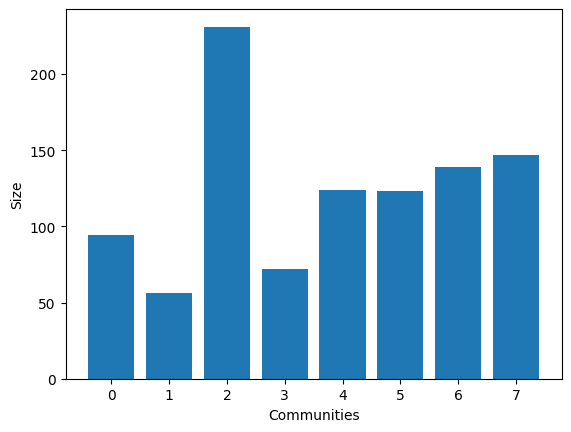

In [149]:
G= nx.Graph(A_real)
# remove self-loops
G.remove_edges_from(nx.selfloop_edges(G))

# extract the largest connected component
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
G = G.subgraph(largest_component)
print('Largest component size:', len(largest_component))




communities = nx.community.louvain_communities(G)
#communities = nx.community.label_propagation_communities(G)

print('Number of communities:', len(communities))

# hist of community sizes
sizes = [len(community) for community in communities]
plt.bar(range(len(sizes)),sizes)
plt.xlabel('Communities')
plt.ylabel('Size')
plt.show()

In [150]:
# Laplacian spectral layout with communities as colors
pos = nx.spectral_layout(G)

/Users/fdurazzi/.venvs/base/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


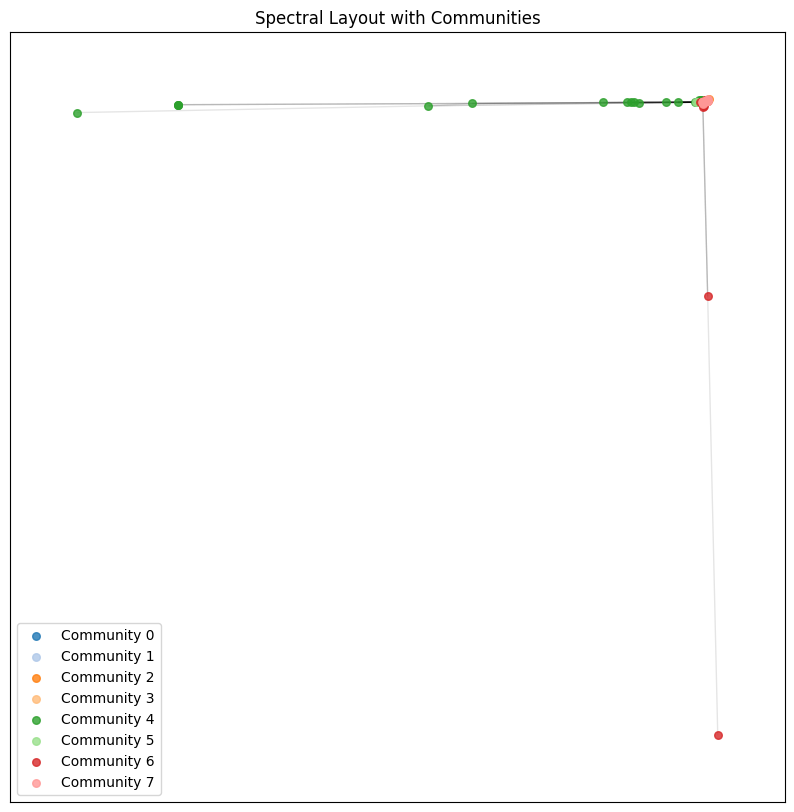

In [151]:
# Plot spectral layout with communities as colors
plt.figure(figsize=(10, 10))
for i, community in enumerate(communities):
    nodes = list(community)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=plt.cm.tab20(i),
                            label=f'Community {i}', node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Spectral Layout with Communities')
plt.legend()
plt.show()

In [152]:
# Force-directed layout (springs and repulsion)
pos= nx.kamada_kawai_layout(G)


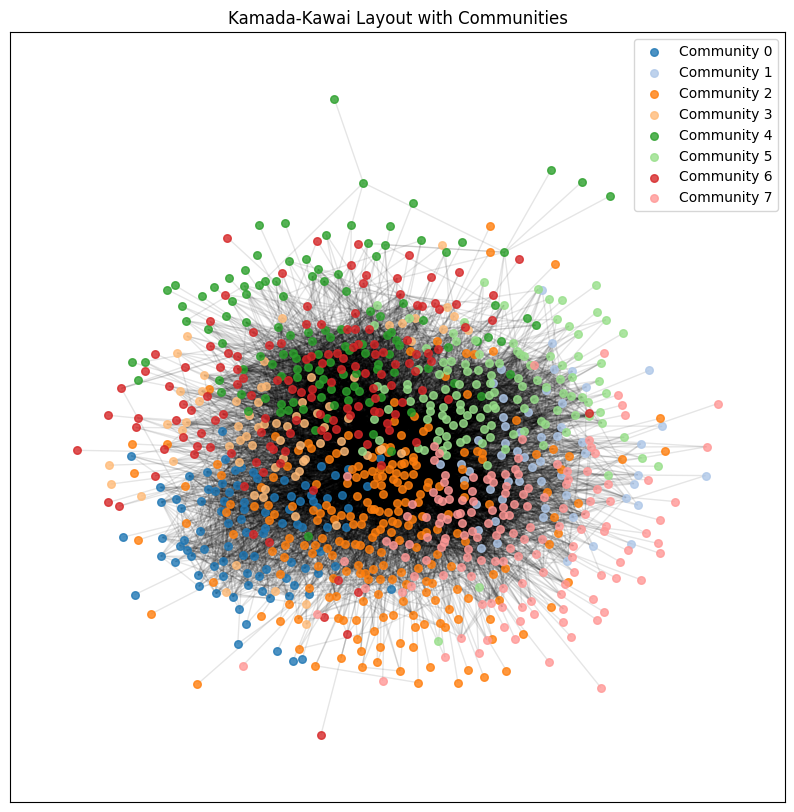

In [153]:
plt.figure(figsize=(10, 10))
for i, community in enumerate(communities):
    nodes = list(community)
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=plt.cm.tab20(i),
                            label=f'Community {i}', node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('Kamada-Kawai Layout with Communities')
plt.legend()
plt.show()

## iGraph 

In [137]:
import igraph as ig

In [165]:
G=nx.Graph(A_real)
G.remove_edges_from(nx.selfloop_edges(G))
# Extract the largest connected component
components = list(nx.connected_components(G))
largest_component = max(components, key=len)
G = G.subgraph(largest_component).copy()


# Convert the NetworkX graph to igraph
node_names= list(G.nodes())
G_igraph = ig.Graph.from_networkx(G)
# Set the vertex names (because we removed nodes outside the largest component)
G_igraph.vs['name'] = node_names

/Users/fdurazzi/.venvs/base/lib/python3.13/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


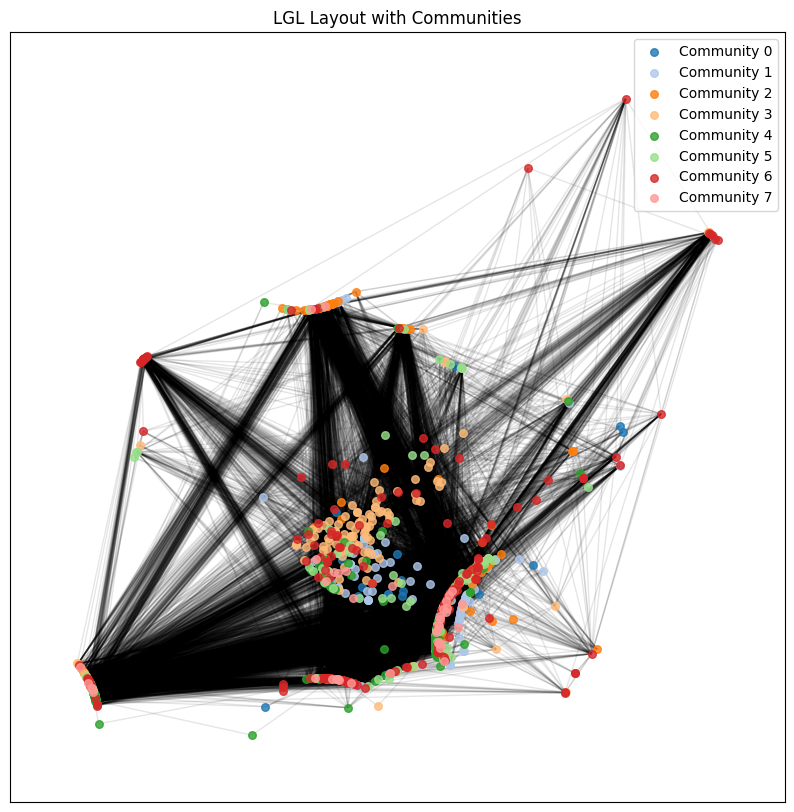

In [166]:
# Communities with leading eigenvector (divisive recursive algorithm)
communities = G_igraph.community_leading_eigenvector()

# Layout with lgl
layout = G_igraph.layout("lgl")
pos = {G_igraph.vs[i]["name"]: layout[i] for i in range(len(layout))}

# Plot the graph with communities
plt.figure(figsize=(10, 10))
for i, community in enumerate(communities):
    nodes = list(community)
    # Convert node indices to names
    nodes = [G_igraph.vs[node]["name"] for node in nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=nodes, node_color=plt.cm.tab20(i),
                            label=f'Community {i}', node_size=30, alpha=0.8)
nx.draw_networkx_edges(G, pos, alpha=0.1)
plt.title('LGL Layout with Communities')
plt.legend()
plt.show()